<div style="background-color: #FFEB3B; border-radius: 15px; padding: 20px; color: #4E342E; text-align: center; font-weight: 800; font-size: 24px;">

## Introduction
</div>

<div style="background-color: #FFEB3B; border-radius: 15px; padding: 20px; color: #4E342E; text-align: center; font-weight: 800; font-size: 18px; margin-top: 20px;">

# Importing Libraries and Loading the Dataset
</div>

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [15]:
data_dir = '/kaggle/input/banana-disease-recognition-dataset/Banana Disease Recognition Dataset/Augmented images/Augmented images'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 2287 images belonging to 7 classes.
Found 569 images belonging to 7 classes.


In [16]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [17]:
class_weights

{0: 0.868920972644377,
 1: 1.1668367346938775,
 2: 0.6778304682868999,
 3: 0.6778304682868999,
 4: 1.060760667903525,
 5: 1.4204968944099379,
 6: 2.532668881506091}

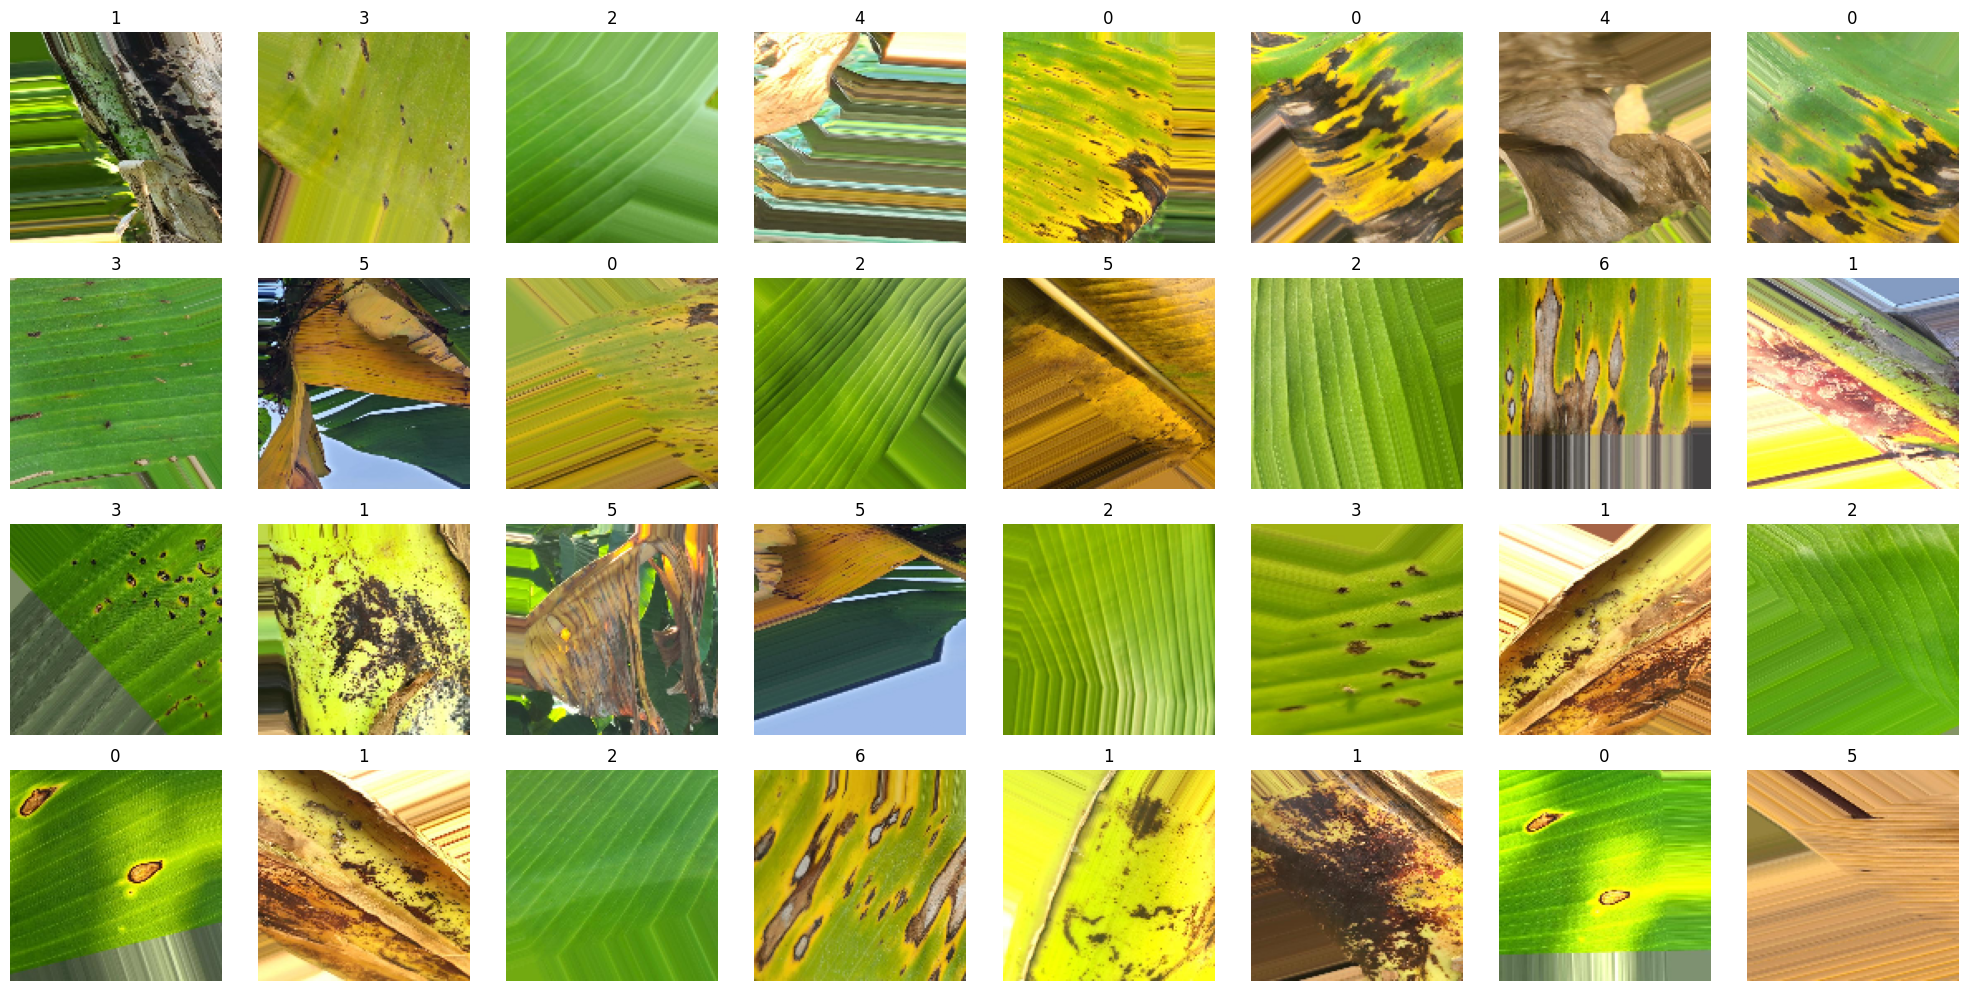

In [18]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

In [19]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

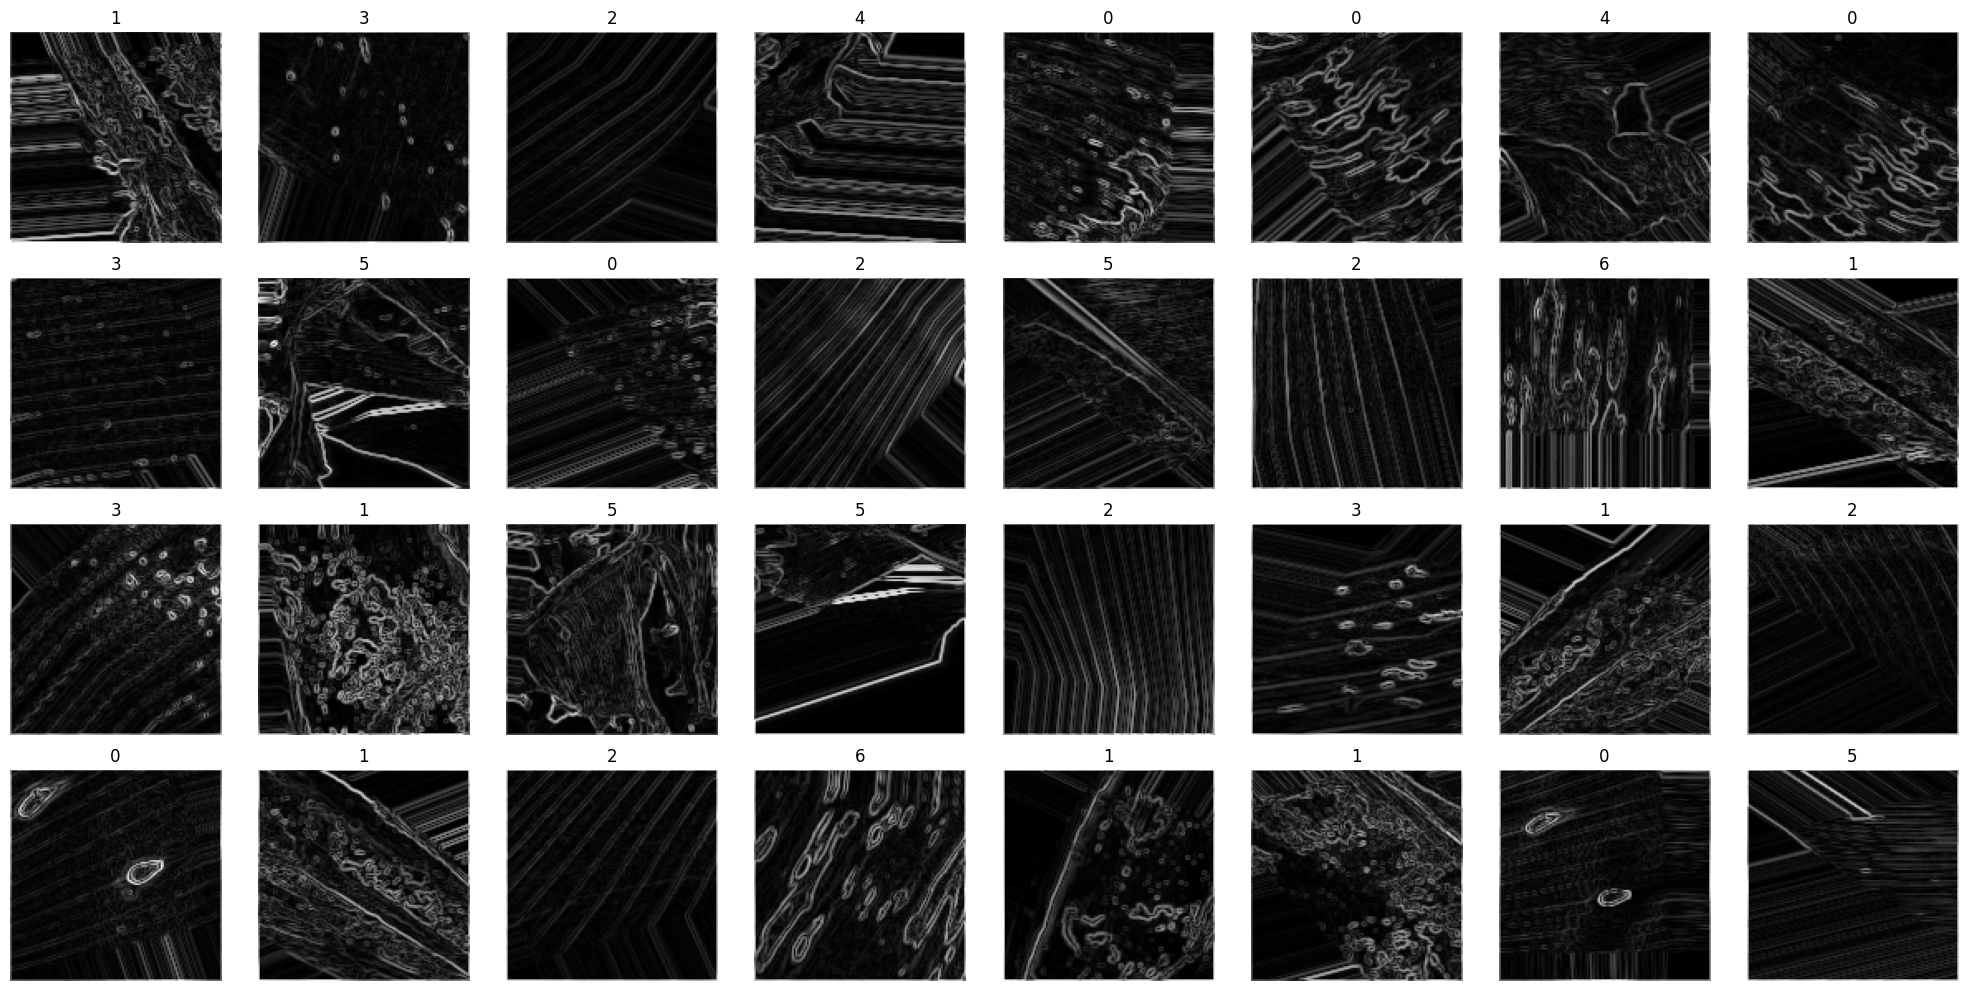

In [20]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [23]:
type(train_generator)

keras.src.legacy.preprocessing.image.DirectoryIterator

<div style="background-color: #FFEB3B; border-radius: 15px; padding: 20px; color: #4E342E; text-align: center; font-weight: 800; font-size: 24px; margin-top: 20px;">

## Building Models 
</div>

## Custom CNN

In [24]:
model_lenet = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

In [25]:
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_lenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,275,303 (4.86 MB)

 Trainable params: 1,273,575 (4.86 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [26]:
history_lenet = model_lenet.fit(train_generator, epochs=50, validation_data=val_generator, class_weight=class_weights)

Epoch 1/50


2024-07-02 20:20:25.290217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-07-02 20:20:25.290280: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-07-02 20:20:25.290289: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-07-02 20:20:25.290297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-07-02 20:20:25.290311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-07-02 20:20:25.290319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-07-02 20:20:25.290326: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-07-02 20:20:25.290334:

 1/72 ━━━━━━━━━━━━━━━━━━━━ 28:35 24s/step - accuracy: 0.1250 - loss: 2.9214 - precision: 0.1667 - recall: 0.0938

I0000 00:00:1719951636.668887     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/72 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.1954 - loss: 2.8385 - precision: 0.2207 - recall: 0.1229

2024-07-02 20:20:47.263330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16425: 4.84597, expected 4.25437
2024-07-02 20:20:47.263412: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20279: 4.78513, expected 4.19353
2024-07-02 20:20:47.263453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 25317: 4.89091, expected 4.29931
2024-07-02 20:20:47.263465: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26336: 4.84597, expected 4.25437
2024-07-02 20:20:47.263489: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30190: 4.78513, expected 4.19353
2024-07-02 20:20:47.263628: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63557: 5.82468, expected 5.13434
2024-07-02 20:20:47.263639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63565: 5.34452, expected 4.65418
2024-07-02 20:20:47.263651:

70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.2572 - loss: 2.5044 - precision: 0.2896 - recall: 0.1711

2024-07-02 20:21:08.587945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 178: 5.39819, expected 4.73177
2024-07-02 20:21:08.588002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 342: 5.41784, expected 4.75142
2024-07-02 20:21:08.588013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 550: 5.14397, expected 4.47755
2024-07-02 20:21:08.588021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 676: 5.36842, expected 4.702
2024-07-02 20:21:08.588032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1239: 5.5656, expected 4.89918
2024-07-02 20:21:08.588040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1365: 5.08219, expected 4.41577
2024-07-02 20:21:08.588053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2697: 5.50892, expected 4.8425
2024-07-02 20:21:08.588062: E external/loc

72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 475ms/step - accuracy: 0.2602 - loss: 2.4890 - precision: 0.2928 - recall: 0.1736 - val_accuracy: 0.2759 - val_loss: 2.8645 - val_precision: 0.2881 - val_recall: 0.2460
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.3816 - loss: 1.7621 - precision: 0.4262 - recall: 0.2811 - val_accuracy: 0.2478 - val_loss: 2.7832 - val_precision: 0.2936 - val_recall: 0.2250
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.4122 - loss: 1.5579 - precision: 0.4611 - recall: 0.3085 - val_accuracy: 0.2654 - val_loss: 2.1708 - val_precision: 0.2044 - val_recall: 0.0808
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.4280 - loss: 1.5004 - precision: 0.4989 - recall: 0.3176 - val_accuracy: 0.3972 - val_loss: 1.9095 - val_precision: 0.4726 - val_recall: 0.3480
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4728 - loss: 1.3236 - precision: 0.5425 - recall: 0.3540 - val_accuracy: 0.4868 - val_loss: 1.5691 - val_pr

## ResNet50 Model

In [33]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
base_model_resnet.trainable = False
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_resnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [35]:
history_resnet = model_resnet.fit(train_generator, epochs=50, validation_data=val_generator, class_weight=class_weights)

Epoch 1/50
 3/72 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.0972 - loss: 2.2882 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00  

W0000 00:00:1719952253.574825     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2663 - loss: 1.8983 - precision_1: 0.3733 - recall_1: 0.0398

W0000 00:00:1719952269.902158     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.2687 - loss: 1.8927 - precision_1: 0.3783 - recall_1: 0.0408 - val_accuracy: 0.1634 - val_loss: 2.1642 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.4441 - loss: 1.4890 - precision_1: 0.5650 - recall_1: 0.1226 - val_accuracy: 0.0562 - val_loss: 2.1615 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.4532 - loss: 1.3784 - precision_1: 0.6396 - recall_1: 0.1617 - val_accuracy: 0.1406 - val_loss: 2.1085 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5052 - loss: 1.3138 - precision_1: 0.6378 - recall_1: 0.2046 - val_accuracy: 0.0562 - val_loss: 2.3485 - val_precision_1: 0.0588 - val_recall_1: 0.0562
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.5402 - loss: 1.2208 - precision_1: 0.6571 - recal

## InceptionV3 Model

In [38]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


model_inception = Sequential([
    base_model_inception,
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
base_model_inception.trainable = False
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_inception.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [40]:
history_inception = model_inception.fit(train_generator, epochs=50, validation_data=val_generator, class_weight=class_weights)

Epoch 1/50
 4/72 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.1296 - loss: 2.6650 - precision_2: 0.1258 - recall_2: 0.0697

W0000 00:00:1719952990.073685     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4783 - loss: 1.5986 - precision_2: 0.5824 - recall_2: 0.3895

W0000 00:00:1719953011.294896     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 417ms/step - accuracy: 0.4815 - loss: 1.5883 - precision_2: 0.5856 - recall_2: 0.3929 - val_accuracy: 0.6819 - val_loss: 1.0171 - val_precision_2: 0.7129 - val_recall_2: 0.6415
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7777 - loss: 0.6219 - precision_2: 0.8468 - recall_2: 0.7119 - val_accuracy: 0.7645 - val_loss: 0.6946 - val_precision_2: 0.8016 - val_recall_2: 0.7170
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8557 - loss: 0.4422 - precision_2: 0.8945 - recall_2: 0.7983 - val_accuracy: 0.7170 - val_loss: 0.7932 - val_precision_2: 0.7665 - val_recall_2: 0.6749
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8787 - loss: 0.3419 - precision_2: 0.9169 - recall_2: 0.8430 - val_accuracy: 0.7715 - val_loss: 0.6056 - val_precision_2: 0.8111 - val_recall_2: 0.7469
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9140 - loss: 0.2524 - precision_2: 0.9420 - recall_2: 0.8872 - val_accuracy:

<div style="background-color: #FFEB3B; border-radius: 15px; padding: 20px; color: #4E342E; text-align: center; font-weight: 800; font-size: 24px; margin-top: 20px;">

## Result and Comparison 
</div>

In [27]:
def plot_performance(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

In [28]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    print(cr)

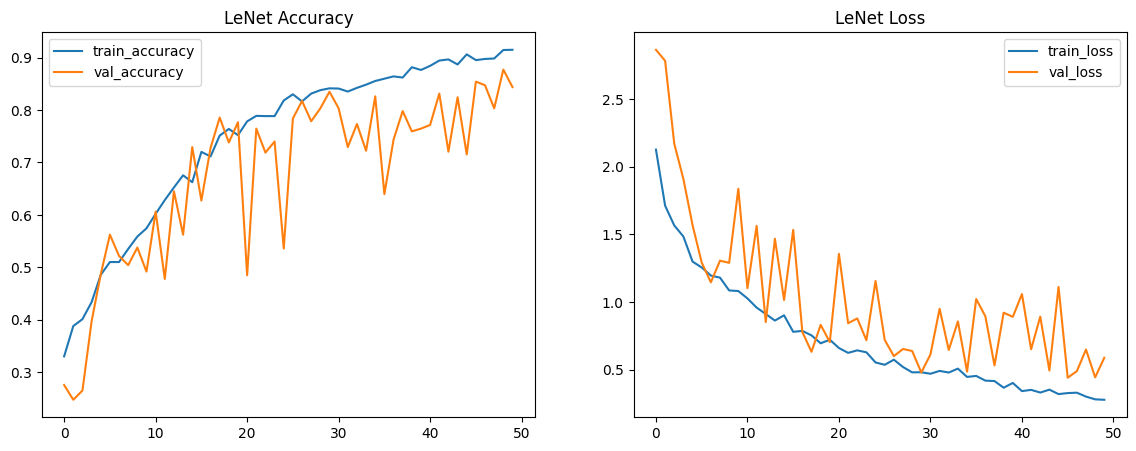

In [29]:
plot_performance(history_lenet, 'LeNet')

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step


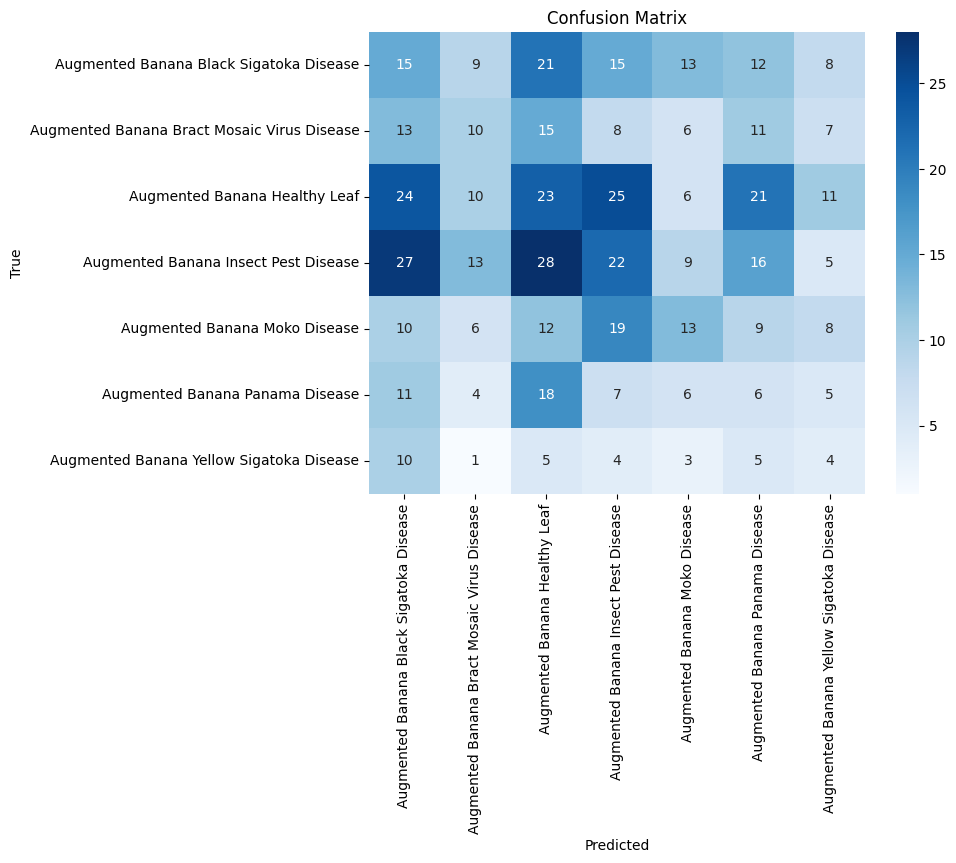

Classification Report:
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.14      0.16      0.15        93
Augmented Banana Bract Mosaic Virus Disease       0.19      0.14      0.16        70
              Augmented Banana Healthy Leaf       0.19      0.19      0.19       120
       Augmented Banana Insect Pest Disease       0.22      0.18      0.20       120
              Augmented Banana Moko Disease       0.23      0.17      0.20        77
            Augmented Banana Panama Disease       0.07      0.11      0.09        57
   Augmented Banana Yellow Sigatoka Disease       0.08      0.12      0.10        32

                                   accuracy                           0.16       569
                                  macro avg       0.16      0.15      0.15       569
                               weighted avg       0.18      0.16      0.17       569



In [30]:
evaluate_model(model_lenet, val_generator)

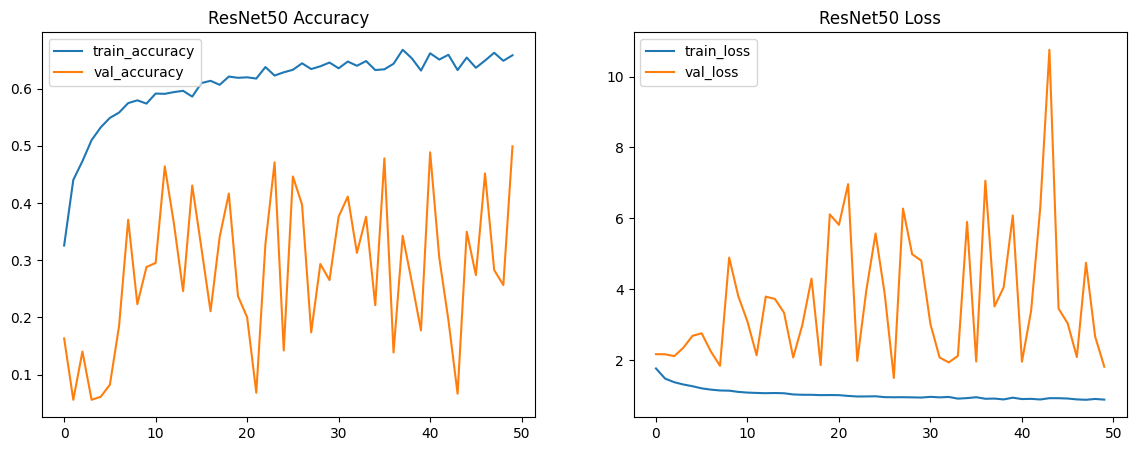

In [36]:
plot_performance(history_resnet, 'ResNet50')

 4/18 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

W0000 00:00:1719952944.428253     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step


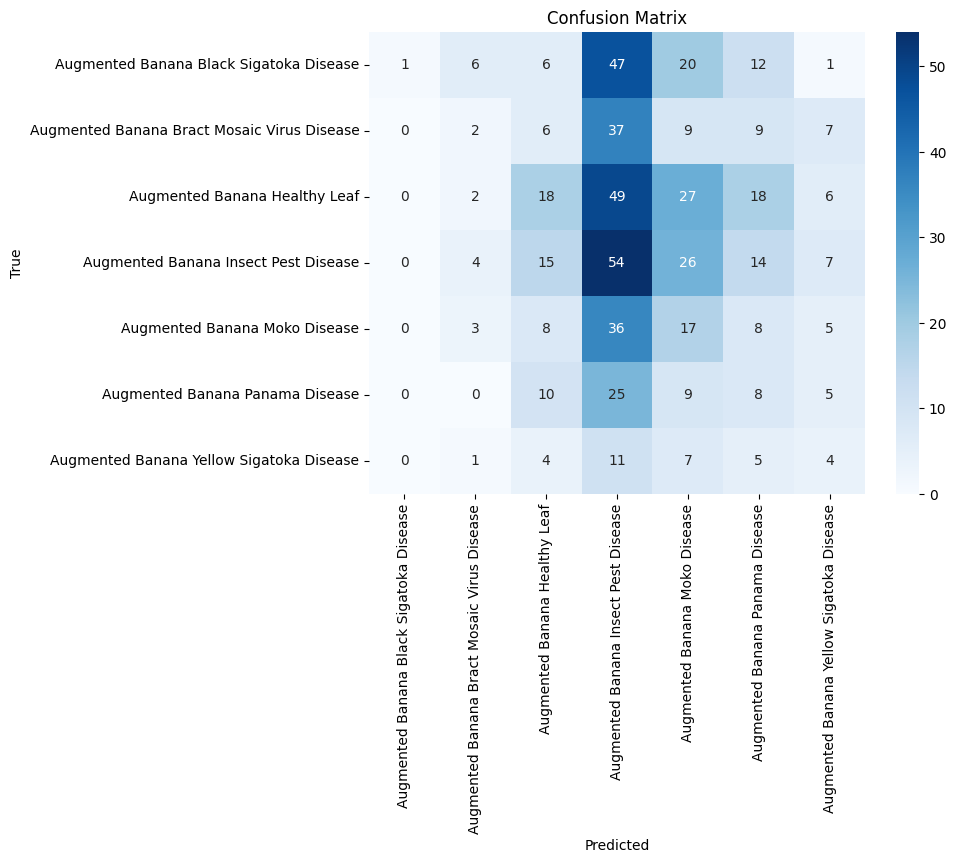

Classification Report:
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       1.00      0.01      0.02        93
Augmented Banana Bract Mosaic Virus Disease       0.11      0.03      0.05        70
              Augmented Banana Healthy Leaf       0.27      0.15      0.19       120
       Augmented Banana Insect Pest Disease       0.21      0.45      0.28       120
              Augmented Banana Moko Disease       0.15      0.22      0.18        77
            Augmented Banana Panama Disease       0.11      0.14      0.12        57
   Augmented Banana Yellow Sigatoka Disease       0.11      0.12      0.12        32

                                   accuracy                           0.18       569
                                  macro avg       0.28      0.16      0.14       569
                               weighted avg       0.32      0.18      0.15       569



In [37]:
evaluate_model(model_resnet, val_generator)

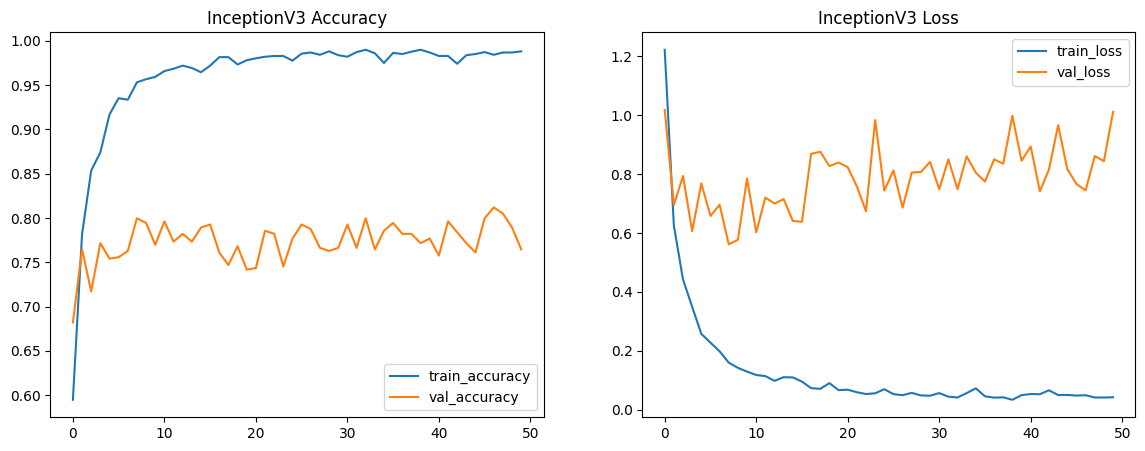

In [41]:
plot_performance(history_inception, 'InceptionV3')

 4/18 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

W0000 00:00:1719953574.947176     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 404ms/step


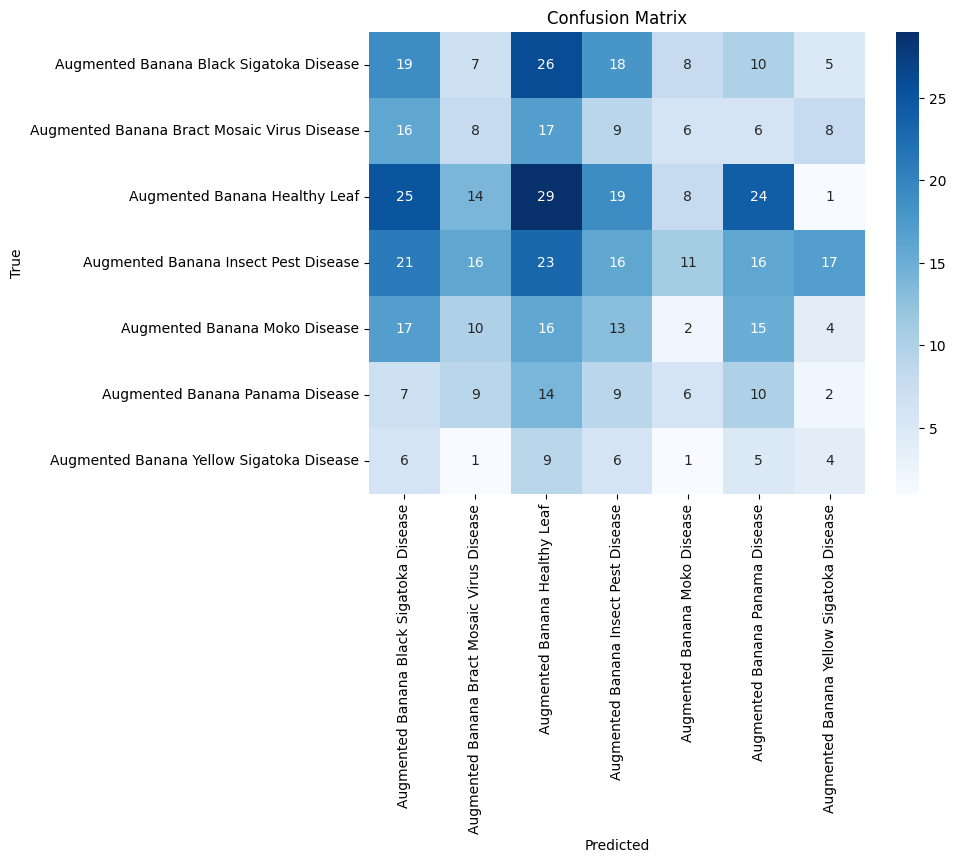

Classification Report:
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.17      0.20      0.19        93
Augmented Banana Bract Mosaic Virus Disease       0.12      0.11      0.12        70
              Augmented Banana Healthy Leaf       0.22      0.24      0.23       120
       Augmented Banana Insect Pest Disease       0.18      0.13      0.15       120
              Augmented Banana Moko Disease       0.05      0.03      0.03        77
            Augmented Banana Panama Disease       0.12      0.18      0.14        57
   Augmented Banana Yellow Sigatoka Disease       0.10      0.12      0.11        32

                                   accuracy                           0.15       569
                                  macro avg       0.14      0.15      0.14       569
                               weighted avg       0.15      0.15      0.15       569



In [42]:
evaluate_model(model_inception, val_generator)

In [32]:
model_lenet.save('model_lenet.h5')

In [44]:
model_resnet.save('model_resnet.h5')

In [43]:
model_inception.save('model_inception.h5')

In [55]:
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size) 
    img_array = img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0 
    return img_array

class_mapping = {
    0: "Banana Black Sigatoka Disease",
    1: "Banana Bract Mosaic Virus Disease",
    2: "Banana Healthy Leaf",
    3: "Banana Insect Pest Disease",
    4: "Banana Moko Disease",
    5: "Banana Panama Disease",
    6: "Banana Yellow Sigatoka Disease"
}

# Function to predict using each model and aggregate predictions
def predict_with_voting(image_path):
    input_size = (128, 128)

    img_lenet = preprocess_image(image_path, input_size)
    img_resnet = preprocess_image(image_path, input_size)
    img_inception = preprocess_image(image_path, input_size)
    
    # Step 1: Make predictions using each model
    pred_lenet = model_lenet.predict(img_lenet)
    pred_resnet = model_resnet.predict(img_resnet)
    pred_inception = model_inception.predict(img_inception)
    
    # Step 2: Aggregate predicted probabilities (soft voting)
    # Soft voting: Average the predicted probabilities
    final_pred_prob = (pred_lenet + pred_resnet + pred_inception) / 3 

    # Step 3: Predict class based on the aggregated probabilities
    final_pred_class = np.argmax(final_pred_prob, axis=1)
    
    # Map predicted class indices to disease names
    final_pred_disease = [class_mapping[class_index] for class_index in final_pred_class]

    return final_pred_disease

image_path = '/kaggle/input/banana-disease-recognition-dataset/Banana Disease Recognition Dataset/Augmented images/Augmented images/Augmented Banana Healthy Leaf/Augmented Banana Healthy Leaf (102).jpg' 
predicted_class = predict_with_voting(image_path)
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Class: ['Banana Healthy Leaf']


In [56]:
image_path = '/kaggle/input/banana-disease-recognition-dataset/Banana Disease Recognition Dataset/Augmented images/Augmented images/Augmented Banana Panama Disease/Augmented Banana Panama Disease (10).jpg' 
predicted_class = predict_with_voting(image_path)
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Class: ['Banana Panama Disease']
